## **분류실습 : 캐글 신용카드 사기 검출**

데이터 다운로드 : https://www.kaggle.com/mlg-ulb/creditcardfraud

### ML 모델 구축
- 다양한 Feature Engineering 방식을
- 로지스틱 회귀와 lightgbm 방식을 이용하여
- 각 방식에 적용 후 평가 비교

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('../creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
card_df.shape

(284807, 31)

In [4]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### - creditcard 피처 정보
- time : 분석에 큰 의미가 없음 -> 삭제
- Amount : 신용카드 트랜젝션 금액
- class : 0-정상, 1-사기

In [6]:
# 전처리 함수 
# - Time 칼럼만 삭제
# - 원본 데이터 유지하고, 복사본 반환
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

### 학습과 테스트 데이터 세트를 반환하는 함수 생성

In [8]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # stratify => y_test비중에 맞게 학습과 테스트를 나눈다
    X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,
                                                             test_size=0.3,
                                                              random_state=0,
                                                             stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

### 학습/테스트 데이터 레이블 비율

In [12]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [11]:
y_train.shape

(199364,)

In [13]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


---

#### LogisticRegression 알고리즘 적용하여 학습/예측/평가 수행

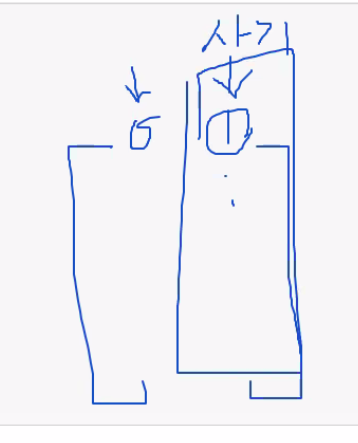

In [14]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1] # 0,1중 정답값의 확률

In [15]:
# 예측 평가 수행
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
 F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [17]:
get_clf_eval(y_test,lr_pred,lr_pred_proba)
# 재현율을 봐야한다! 
# 데이터 불균형으로 인해 정확도가 높지만 재현율이 떨어짐

오차 행렬
[[85280    15]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8598, 재현율: 0.6216, F1: 0.7216, AUC:0.9577


---

## ***모델을 학습/예측/평가를 위한 함수 생성***

In [18]:
###
def get_model_train_eval(model, ftr_train=None, ftr_test=None,
                        tgt_train=None, tgt_test=None):
    model.fit(ftr_train,tgt_train)  # 학습
    pred=model.predict(ftr_test)  # 예측
    pred_proba = model.predict_proba(ftr_test)[:,1] # 예측확률
    get_clf_eval(tgt_test, pred, pred_proba)  # 평가
    
###

---

## LightGBM 학습/예측/평가

In [19]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                         n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train, X_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


### 중요 데이터 분포도 변환 후 모델 학습/예측/평가

중요 feature 분포도 확인

<AxesSubplot:xlabel='Amount', ylabel='Density'>

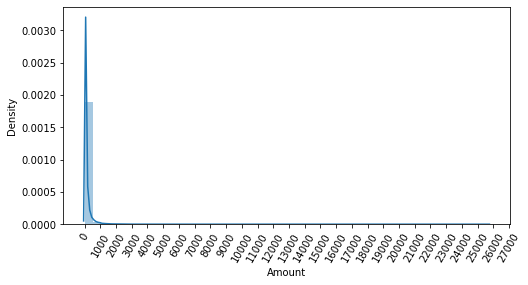

In [23]:
# 중요 속성으로 Amout 선정해서 분포도 확인
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

### 전처리 함수: get_preprocessed_df() 수정
- StandardScaler를 이용하여 Amount 피처 변환 추가

In [29]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 Dataframe앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n) ###
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [30]:
# get_preprocessed_df -> get_train_test_dataset(card_df)
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [31]:
# 확인
card_df2 = get_preprocessed_df(card_df)
card_df2.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [32]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightBGM수행
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                         n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9779


<AxesSubplot:xlabel='Amount_Scaled', ylabel='Density'>

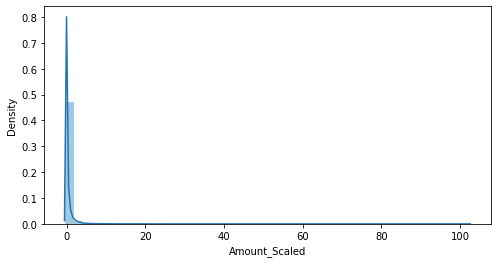

In [34]:
# 중요 속성으로 Amout 선정해서 분포도 확인
import seaborn as sns

plt.figure(figsize=(8,4))
# plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df2['Amount_Scaled'])


### 전처리 함수3 : get_preprocessed_df() 수정
- 비대칭 분포를 갖는 Amount 피처를 로그 변환

In [36]:
# 비대칭 분포 변환
# positive -> log변환
# negative -> 지수변환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
#     scaler = StandardScaler()
#     amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    '''
    넘파이듸 로그 변환 함수는 np.log()인데
    보통 로그 변환할 때 log() 잘 안쓰고 log1p() 사용
    log()에 1을 더하면 0이 됨
    '''
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 Dataframe앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n) ###
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [37]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightBGM수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                         n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9796


In [38]:
# 확인
card_df2 = get_preprocessed_df(card_df)
card_df2.head()

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,5.014760,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.305626,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.939276,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,4.824306,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,4.262539,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<AxesSubplot:xlabel='Amount_Scaled', ylabel='Density'>

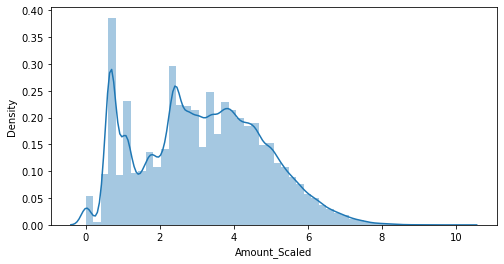

In [39]:
# 중요 속성으로 Amout 선정해서 분포도 확인
import seaborn as sns

plt.figure(figsize=(8,4))
# plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df2['Amount_Scaled'])


---

### 이상치 데이터 제거 후 모델 학습/예측/평가

#### 각 피처들의 상관 관계 시각화 : 히트맵(headmap)
- 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출
- 추출한 다음 이 중에 상관도가 높은 피처들에 대해서 아웃라이어 찾음
- 그 다음에 대한 아웃 라이어가 높은 피처들을 가지고 있는 레코드 삭제
- 상관관계 -1 < r < 1 1과 -1일에 가까울 수록 강한상관관계

<AxesSubplot:>

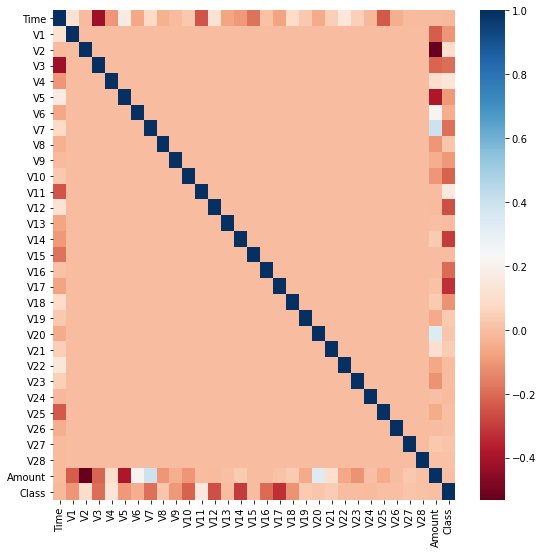

In [40]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

=> 레이블 Class와 상관관계가 가장 높은 피처는 v14와 v17(음의 상관관계)

### 이상치 탐지
- IQR, 사분위수, Boxplot을 이용
    - 최대값 : 3분위수 + 1.5*IQR
    - 최소값 : 1분위수 - 1.5*IQR

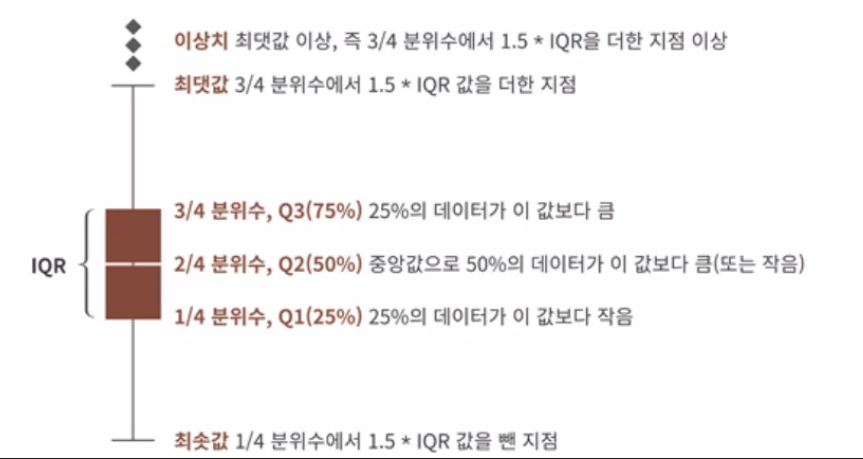

In [50]:
# 아웃라이어를 찾기 위한 함수 새로 생성
import numpy as np

# 전체 데이터에서 찾지 않고 사기 데이터(class가 1인)에서 찾음
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을
    # np.percentile로 구함
    fraud =df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고
    # DataFrame index로 반환
    outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index
    
    return outlier_index

#### 피처 v14의 분포
- 사분위수

In [51]:
outlier_index = get_outlier(df=card_df, column='V14',weight=1.5)
outlier_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

<AxesSubplot:xlabel='V14', ylabel='Density'>

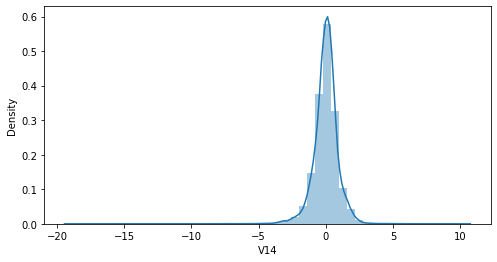

In [52]:
# 중요 속성으로 Amout 선정해서 분포도 확인
import seaborn as sns

plt.figure(figsize=(8,4))
sns.distplot(card_df2['V14'])

In [53]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n) ###
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=card_df, column='V14',weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True) # axis=0 행삭제
    
    return df_copy

### 로그 변환, 이상치 제거 후 모델들을 재 학습/예측/평가

In [55]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightBGM수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,X_train, X_test, y_train, y_test)
print('')
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [58]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote =SMOTE(random_state=0)

### 중요! ###
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

# 전체 데이터 :284,807
# 테스트 :30% , train:70%
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',X_train.shape,y_train.shape)
print('SMOTE 적용 전 레이블 값 분포 : \n:',pd.Series(y_train).value_counts(),'\n')
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n:',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 전 레이블 값 분포 : 
: 0    199020
1       342
Name: Class, dtype: int64 

SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
: 0    199020
1    199020
Name: Class, dtype: int64


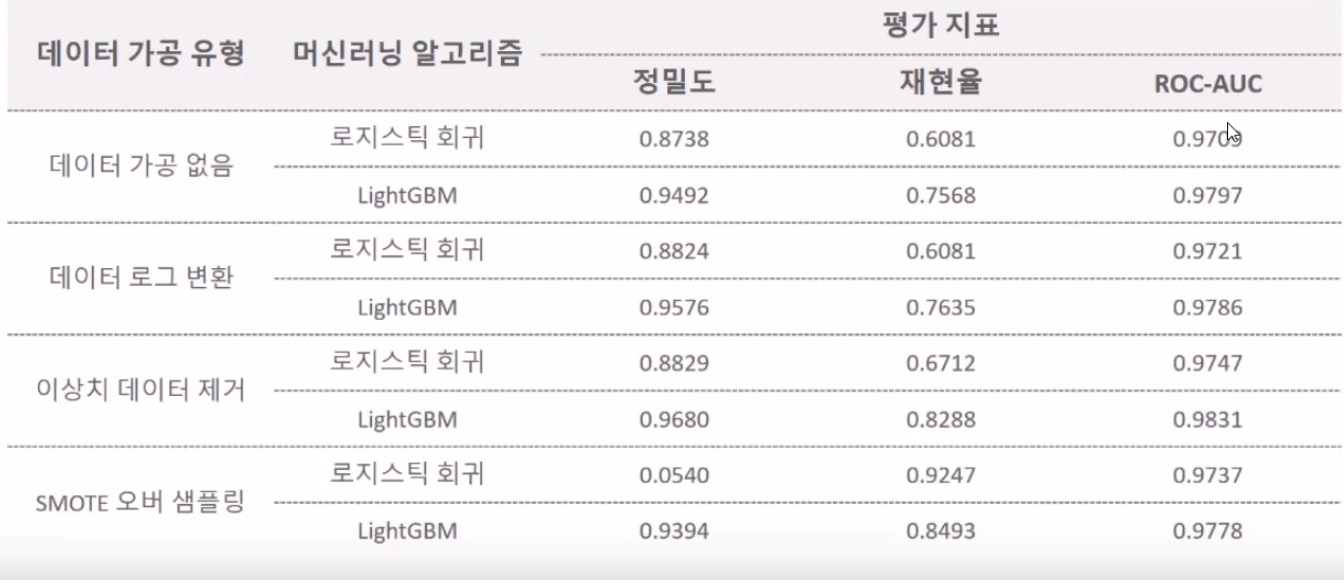

### 오버샘플링된 데이터로 로지스틱 회귀로 학습/예측/평가

In [59]:
# 증식된 데이터에 기반해서 다시 모델 학습/예측/평가
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


### 오버 샘플링 재현율/정밀도 시각화

In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()


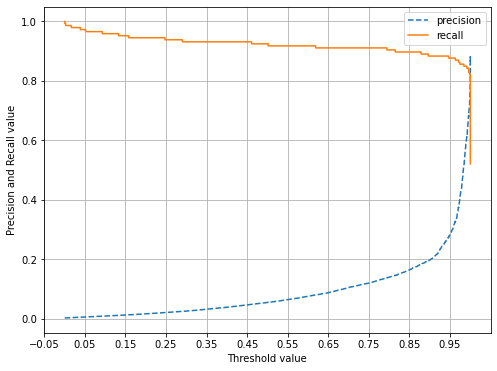

In [62]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 오버샘플링된 데이터로 LightGBM 모델 적용

In [64]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                         n_jobs=-1, boost_from_average=False)

# 오버샘플링된 데이터 세트 사용
get_model_train_eval(lgbm_clf,X_train_over, X_test, 
                     y_train_over, y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


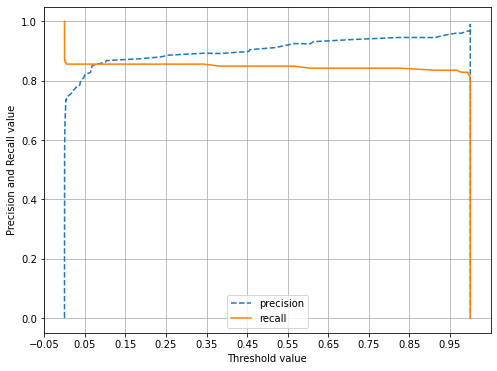

In [65]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,1])